In [1]:
import time, os, random
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.distributions.categorical import Categorical
import matplotlib as mpl
from scipy.stats import ortho_group, special_ortho_group
import copy
from sklearn import metrics, cluster
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.io
from torch.distributions.beta import Beta
from sklearn.cluster import KMeans
import matplotlib.animation as manimation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_svmlight_file
import argparse
from method import *


# Setting

In [7]:
random_seedS = [42]
device = "cuda:2"
dataset_name = "Pendigits"  # Connect-4  Covtype  Glass Letter  Pendigits Satimage  Seismic Svmguide2 Vehicle
data_size = 'small'
chunk_size = 1500
data_type = "mat"
split_data = True
train_path = "./dataset/pendigits/pendigits_train.mat"
test_path = './dataset/pendigits/pendigits_test.mat'
x_dim = 16
Niter = 10000
NITnei = 5
num_component = 12
a_beta = 5
b_beta = 1
eps = 1e-2
Amethod = 'orthogonal'
Amode = 'rand'
alpha_pi = 1. / num_component

out_dir = "./ExperiResults/"
os.makedirs(out_dir) if not os.path.isdir(out_dir) else None

# <1> Joint-EM for clustering

Pendigits Start, round 0, seed=42!
seed=42, method=Joint, NMI=0.7836154949063802, ARI=0.6480628161447547, LL=10.054335594177246



/home/apple/anaconda3/envs/BL-FT/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


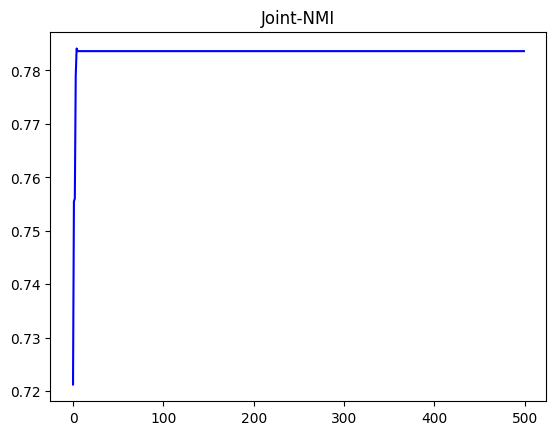

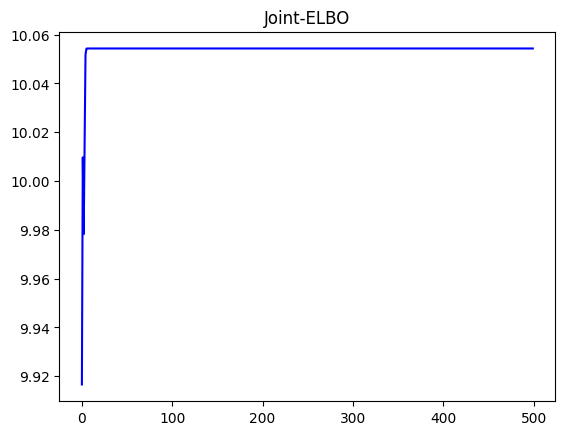

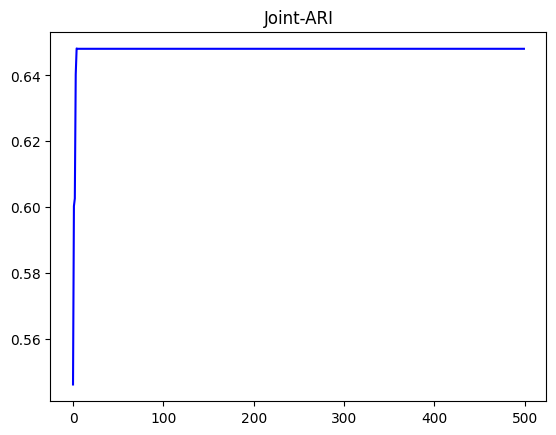

In [11]:
method = "Joint"

Joint_NMI_ALL, Joint_AR_ALL, Joint_LL_ALL = [], [], []

for irand, random_seed in enumerate(random_seedS):
    seed_torch(random_seed)

    print(f'{dataset_name} Start, round {irand}, seed={random_seed}!')

    # ======================================== Load & Process data  =========================================== #
    # Load data
    # normalize train_data using the min-max map to the interval [0, 1]
    X_train, X_test, y_train, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = load_data(
        dataset_name,
        train_path,
        test_path,
        data_type,
        split_data,
        device,
        random_seed
    )

    # ==================================================== Joint-EM  ================================================= #  
    JointITS, Joint_Theta, JointNMI_trainS, JointNMI_testS, train_Joint_LB, test_Joint_LB, Joint_AR_train, Joint_AR_test = joint_EM(
        num_component,
        x_dim,
        X_train_tensor,
        X_test_tensor,
        y_test_tensor,
        Niter,
        eps,
        device,
        data_size,
        chunk_size,
        random_seed
    )
    Joint_NMI_ALL.append(JointNMI_testS[-1])
    Joint_AR_ALL.append(Joint_AR_test[-1])
    Joint_LL_ALL.append(torch.tensor(test_Joint_LB[-1]).cpu())
    print(
        f'seed={random_seed}, method={method}, NMI={Joint_NMI_ALL[-1]}, ARI={Joint_AR_ALL[-1]}, LL={Joint_LL_ALL[-1]}\n')

    # plot NMI
    plt.plot(range(len(JointNMI_testS)), torch.tensor(JointNMI_testS).cpu(), 'b-', label='test-ELBO')
    plt.title(f'Joint-NMI')
    plt.show()

    # plot ELBO
    plt.plot(range(len(test_Joint_LB)), torch.tensor(test_Joint_LB).cpu(), 'b-', label='test-ELBO')
    plt.title(f'Joint-ELBO')
    plt.show()

    # plot ARI
    plt.plot(range(len(Joint_AR_test)), torch.tensor(Joint_AR_test).cpu(), 'b-', label='test-ar score')
    plt.title(f'Joint-ARI')
    plt.show()

# <2> BigLearn-EM

Pendigits Start, round 0, seed=42!
seed=42, method=BL, NMI=0.8399346955565458, ARI=0.759314579910447, LL=10.342240333557129



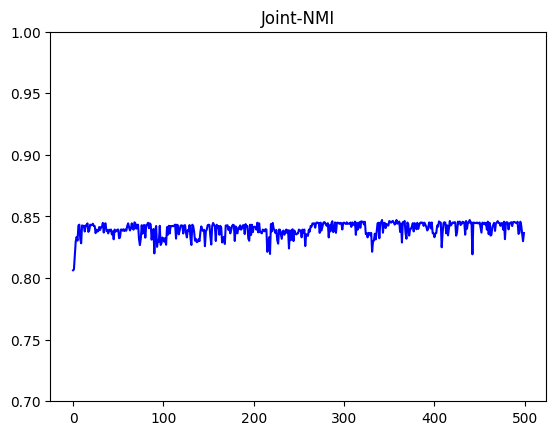

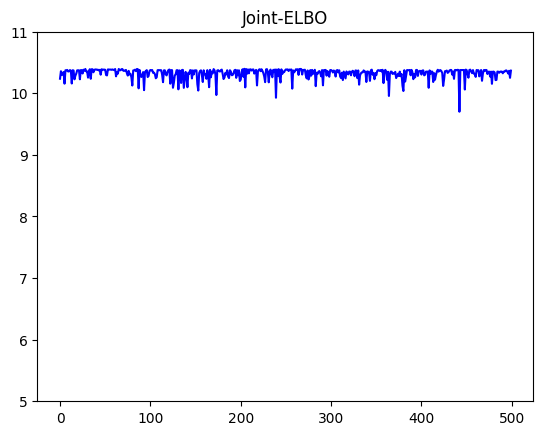

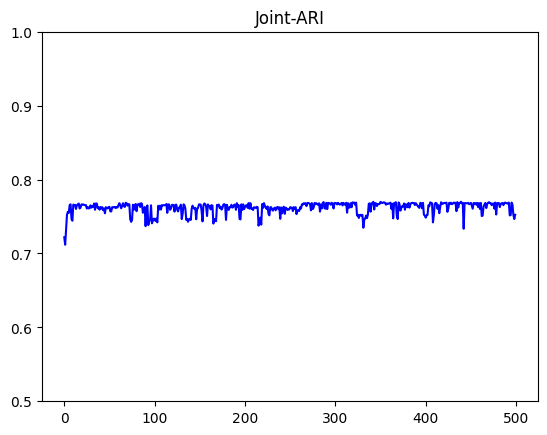

In [9]:
method = "BL"
BL_NMI_ALL, BL_AR_ALL, BL_LL_ALL = [], [], []

for irand, random_seed in enumerate(random_seedS):
    seed_torch(random_seed)

    print(f'{dataset_name} Start, round {irand}, seed={random_seed}!')

    # ======================================== Load & Process data  =========================================== #
    X_train, X_test, y_train, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = load_data(
        dataset_name,
        train_path,
        test_path,
        data_type,
        split_data,
        device,
        random_seed
    )

    # ==================================================== BL-EM  ==================================================== #
    BigLearnITS, BigLearnTheta, BigLearnNMI_trainS, BigLearnNMI_testS, train_BigLearn_LB, test_BigLearn_LB, AR_score_train, AR_score_test = bl_EM(
        num_component,
        x_dim,
        X_train_tensor,
        X_test_tensor,
        y_test_tensor,
        Niter,
        NITnei,
        eps,
        alpha_pi,
        a_beta,
        b_beta,
        Amode,
        Amethod,
        device,
        data_size,
        chunk_size,
        random_seed
    )
    BL_NMI_ALL.append(np.mean(BigLearnNMI_testS[-10:]))
    BL_AR_ALL.append(np.mean(AR_score_test[-10:]))
    BL_LL_ALL.append(torch.tensor(test_BigLearn_LB[-10:]).cpu().mean())

    print(f'seed={random_seed}, method={method}, NMI={BL_NMI_ALL[-1]}, ARI={BL_AR_ALL[-1]}, LL={BL_LL_ALL[-1]}\n')

    # plot NMI
    plt.plot(range(len(BigLearnNMI_testS)), torch.tensor(BigLearnNMI_testS).cpu(), 'b-', label='test-ELBO')
    plt.ylim(0.7, 0.9)
    plt.title(f'BL-NMI')
    plt.show()

    # plot ELBO
    plt.plot(range(len(test_BigLearn_LB)), torch.tensor(test_BigLearn_LB).cpu(), 'b-', label='test-ELBO')
    plt.title(f'BL-ELBO')
    plt.ylim(5, 11)
    plt.show()

    # plot ARI
    plt.plot(range(len(AR_score_test)), torch.tensor(AR_score_test).cpu(), 'b-', label='test-ar score')
    plt.ylim(0.5, 0.9)
    plt.title(f'BL-ARI')
    plt.show()


# Comparison

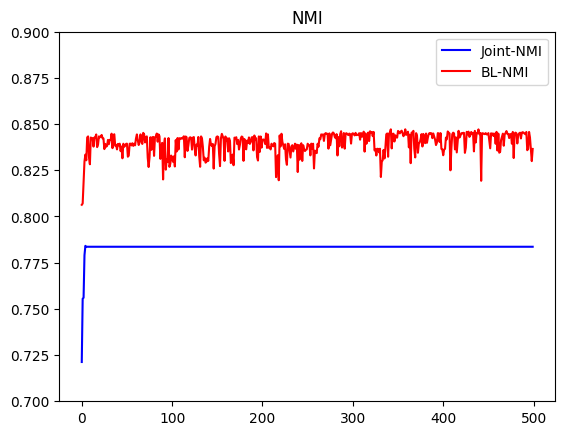

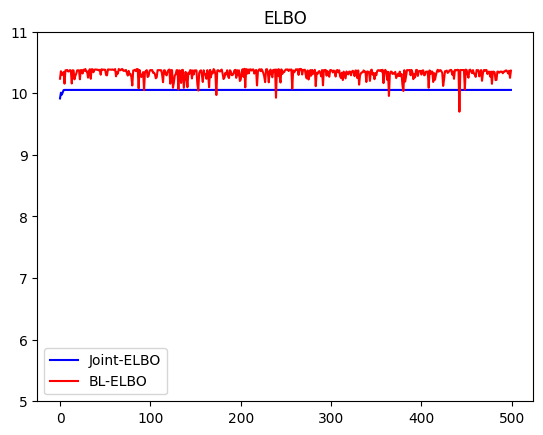

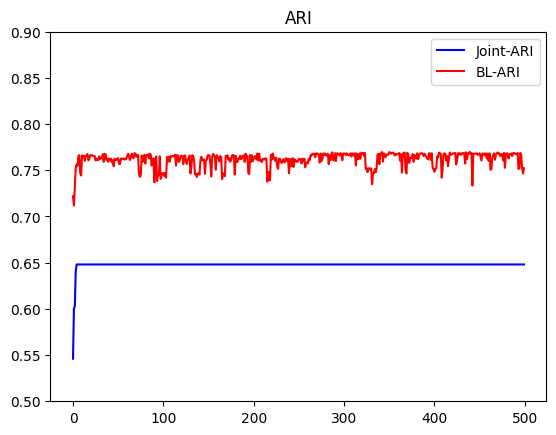

In [13]:
# plot NMI
plt.plot(range(len(JointNMI_testS)), torch.tensor(JointNMI_testS).cpu(), 'b-', label='Joint-NMI')
plt.plot(range(len(BigLearnNMI_testS)), torch.tensor(BigLearnNMI_testS).cpu(), 'r-', label='BL-NMI')
plt.ylim(0.7, 0.9)
plt.title(f'NMI')
plt.legend()
plt.show()

# plot ELBO
plt.plot(range(len(test_Joint_LB)), torch.tensor(test_Joint_LB).cpu(), 'b-', label='Joint-ELBO')
plt.plot(range(len(test_BigLearn_LB)), torch.tensor(test_BigLearn_LB).cpu(), 'r-', label='BL-ELBO')
plt.title(f'ELBO')
plt.ylim(5, 11)
plt.legend()
plt.show()

# plot ARI
plt.plot(range(len(Joint_AR_test)), torch.tensor(Joint_AR_test).cpu(), 'b-', label='Joint-ARI')
plt.plot(range(len(AR_score_test)), torch.tensor(AR_score_test).cpu(), 'r-', label='BL-ARI')
plt.ylim(0.5, 0.9)
plt.title(f'ARI')
plt.legend()
plt.show()